In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
train_df = pd.read_csv("train_E6oV3lV.csv")
test_df = pd.read_csv("test_tweets_anuFYb8.csv")

In [3]:
train_df.info()
print("-----------------------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [13]:
import string
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [5]:
train_df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


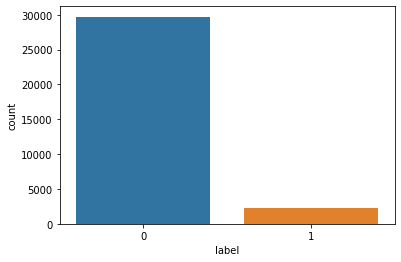

In [6]:
sns.countplot(train_df["label"])

In [20]:
y = train_df["label"]

In [15]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [16]:
train_df['tweet'].head(5).apply(text_process)

0    [user, father, dysfunctional, selfish, drags, ...
1    [user, user, thanks, lyft, credit, cant, use, ...
2                                    [bihday, majesty]
3    [model, love, u, take, u, time, urð±, ðð...
4                    [factsguide, society, motivation]
Name: tweet, dtype: object

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [18]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(train_df['tweet'])

In [19]:
messages_bow = bow_transformer.transform(train_df['tweet'])

In [23]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [24]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(31962, 47386)


In [25]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [26]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [27]:
 #A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [28]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [29]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1', n_jobs=4, cv=skf.split(messages_tfidf,y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(messages_tfidf, y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  9.2min finished



 Time taken: 0 hours 10 minutes and 21.25 seconds.


In [30]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([ 60.30333161, 153.77897898, 177.97211933, 135.66425792,
       149.63329657]), 'std_fit_time': array([ 2.49634143, 29.44663528,  3.22712574,  3.10005759, 12.2638346 ]), 'mean_score_time': array([0.2406884 , 0.6703395 , 0.55345472, 0.60078899, 0.17153494]), 'std_score_time': array([0.03754977, 0.02853958, 0.07846017, 0.11244615, 0.00082219]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_val

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(messages_tfidf,y,test_size=0.3,random_state=101)

In [32]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

In [33]:
from sklearn.metrics import f1_score
def xgb_f1(y, t, threshold=0.5):
    t = t.get_label()
    y_bin = (y > threshold).astype(int) # works for both type(y) == <class 'numpy.ndarray'> and type(y) == <class 'pandas.core.series.Series'>
    return 'f1',f1_score(t,y_bin)

In [34]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric= xgb_f1 , eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.058922	validation_0-f1:0.282084
[1]	validation_0-error:0.059235	validation_0-f1:0.282828
[2]	validation_0-error:0.061842	validation_0-f1:0.218709
[3]	validation_0-error:0.058296	validation_0-f1:0.325694
[4]	validation_0-error:0.058087	validation_0-f1:0.295828
[5]	validation_0-error:0.058817	validation_0-f1:0.275064
[6]	validation_0-error:0.059652	validation_0-f1:0.239362
[7]	validation_0-error:0.059443	validation_0-f1:0.242021
[8]	validation_0-error:0.059026	validation_0-f1:0.24734
[9]	validation_0-error:0.059235	validation_0-f1:0.236559
[10]	validation_0-error:0.059235	validation_0-f1:0.236559
[11]	validation_0-error:0.059965	validation_0-f1:0.21981
[12]	validation_0-error:0.060277	validation_0-f1:0.210383
[13]	validation_0-error:0.061112	validation_0-f1:0.192837
[14]	validation_0-error:0.061112	validation_0-f1:0.192837
[15]	validation_0-error:0.061007	validation_0-f1:0.190871
[16]	validation_0-error:0.061112	validation_0-f1:0.192837
[17]	validation_0-error:0.

[142]	validation_0-error:0.060382	validation_0-f1:0.220727
[143]	validation_0-error:0.060382	validation_0-f1:0.220727
[144]	validation_0-error:0.060277	validation_0-f1:0.223118
[145]	validation_0-error:0.060277	validation_0-f1:0.223118
[146]	validation_0-error:0.060277	validation_0-f1:0.223118
[147]	validation_0-error:0.060382	validation_0-f1:0.220727
[148]	validation_0-error:0.060382	validation_0-f1:0.220727
[149]	validation_0-error:0.060277	validation_0-f1:0.223118
[150]	validation_0-error:0.060277	validation_0-f1:0.223118
[151]	validation_0-error:0.060382	validation_0-f1:0.220727
[152]	validation_0-error:0.060382	validation_0-f1:0.220727
[153]	validation_0-error:0.060382	validation_0-f1:0.220727
[154]	validation_0-error:0.060382	validation_0-f1:0.220727
[155]	validation_0-error:0.060382	validation_0-f1:0.220727
[156]	validation_0-error:0.060382	validation_0-f1:0.220727
[157]	validation_0-error:0.060382	validation_0-f1:0.220727
[158]	validation_0-error:0.060382	validation_0-f1:0.2207

[282]	validation_0-error:0.057879	validation_0-f1:0.278283
[283]	validation_0-error:0.057775	validation_0-f1:0.280519
[284]	validation_0-error:0.057879	validation_0-f1:0.278283
[285]	validation_0-error:0.057879	validation_0-f1:0.278283
[286]	validation_0-error:0.057983	validation_0-f1:0.276042
[287]	validation_0-error:0.057983	validation_0-f1:0.276042
[288]	validation_0-error:0.057879	validation_0-f1:0.278283
[289]	validation_0-error:0.057879	validation_0-f1:0.278283
[290]	validation_0-error:0.057775	validation_0-f1:0.280519
[291]	validation_0-error:0.057775	validation_0-f1:0.280519
[292]	validation_0-error:0.057775	validation_0-f1:0.282383
[293]	validation_0-error:0.057775	validation_0-f1:0.282383
[294]	validation_0-error:0.05767	validation_0-f1:0.284605
[295]	validation_0-error:0.05767	validation_0-f1:0.284605
[296]	validation_0-error:0.05767	validation_0-f1:0.284605
[297]	validation_0-error:0.05767	validation_0-f1:0.284605
[298]	validation_0-error:0.057566	validation_0-f1:0.286822
[

[422]	validation_0-error:0.053916	validation_0-f1:0.37028
[423]	validation_0-error:0.053916	validation_0-f1:0.37028
[424]	validation_0-error:0.053916	validation_0-f1:0.37028
[425]	validation_0-error:0.053916	validation_0-f1:0.37028
[426]	validation_0-error:0.053916	validation_0-f1:0.37028
[427]	validation_0-error:0.053916	validation_0-f1:0.37028
[428]	validation_0-error:0.053916	validation_0-f1:0.37028
[429]	validation_0-error:0.053812	validation_0-f1:0.372263
[430]	validation_0-error:0.053707	validation_0-f1:0.374241
[431]	validation_0-error:0.053707	validation_0-f1:0.374241
[432]	validation_0-error:0.053707	validation_0-f1:0.374241
[433]	validation_0-error:0.053707	validation_0-f1:0.374241
[434]	validation_0-error:0.053707	validation_0-f1:0.374241
[435]	validation_0-error:0.053707	validation_0-f1:0.374241
[436]	validation_0-error:0.053707	validation_0-f1:0.374241
[437]	validation_0-error:0.053707	validation_0-f1:0.374241
[438]	validation_0-error:0.053707	validation_0-f1:0.374241
[439

[562]	validation_0-error:0.052769	validation_0-f1:0.39905
[563]	validation_0-error:0.052769	validation_0-f1:0.39905
[564]	validation_0-error:0.052769	validation_0-f1:0.39905
[565]	validation_0-error:0.052769	validation_0-f1:0.39905
[566]	validation_0-error:0.052769	validation_0-f1:0.39905
[567]	validation_0-error:0.052769	validation_0-f1:0.39905
[568]	validation_0-error:0.051935	validation_0-f1:0.414118
[569]	validation_0-error:0.051935	validation_0-f1:0.414118
[570]	validation_0-error:0.05183	validation_0-f1:0.415981
[571]	validation_0-error:0.05183	validation_0-f1:0.415981
[572]	validation_0-error:0.05183	validation_0-f1:0.415981
[573]	validation_0-error:0.05183	validation_0-f1:0.415981
[574]	validation_0-error:0.05183	validation_0-f1:0.415981
[575]	validation_0-error:0.05183	validation_0-f1:0.415981
[576]	validation_0-error:0.051935	validation_0-f1:0.414118
[577]	validation_0-error:0.05183	validation_0-f1:0.415981
[578]	validation_0-error:0.051726	validation_0-f1:0.41784
[579]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

In [35]:
y_pred = model.predict(X_test)

In [36]:
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8940
           1       0.88      0.28      0.42       649

    accuracy                           0.95      9589
   macro avg       0.91      0.64      0.70      9589
weighted avg       0.95      0.95      0.94      9589



In [38]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', model),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [40]:
pipeline.fit(train_df['tweet'],y)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000128B9D00C18>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=1.5,
                               learning_rate=0.02, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=None,
                    

In [41]:
predictions = pipeline.predict(test_df['tweet'])

In [42]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
submission = pd.DataFrame({ "id": test_df["id"],
                            "label": predictions })
submission.to_csv('submission_XGB.csv', index=False)